In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors
print(os.getcwd())

# PyDMD imports
from pydmd import DMD, MrDMD, FbDMD, SpDMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D, plot_eigs_mrdmd

%matplotlib widget

save = False
plotting = True

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves


In [2]:
def plot_2vars(var1, var2, title1, title2):
    global cont1, cont2
    
    # Set up figure
    non_dim_times = np.arange(len(times))*filter_step*md['SAVE_STATS_DT_FINE']/buoy_per
    print(non_dim_times)
    
    print("Setting up data arrays...")
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    ims = np.array([None,None])
    cb = np.array([None,None])
    
    print("Setting up initial plot...")
    ims[0] = axs[0].pcolormesh(X, Y, var1[-1], cmap='bwr', norm=colors.CenteredNorm())
    ims[1] = axs[1].pcolormesh(X, Y, var2[-1], cmap='bwr', norm=colors.CenteredNorm())
    
    cont1 = axs[0].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    cont2 = axs[1].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    
    cb[0] = plt.colorbar(ims[0],ax=axs[0])
    cb[1] = plt.colorbar(ims[1],ax=axs[1])
    
    ims[0].set_clim(-clim, clim)
    ims[1].set_clim(-clim, clim)
    
    axs[0].set_xlim(*xlims)
    axs[1].set_xlim(*xlims)
    
    fig.suptitle("time = 0 secs")
    axs[0].set_ylabel("$z$")
    axs[1].set_ylabel("$z$")
    axs[0].set_xlabel("$x$")
    axs[1].set_xlabel("$x$")
    
    axs[0].set_aspect(1)
    axs[1].set_aspect(1)
    
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    
    def animate(step):
        global cont1, cont2
        ims[0].set_array(var1[step].ravel())
        ims[1].set_array(var2[step].ravel())
        
        fig.suptitle(r"$t = {0:.2f}\, T_b$".format(non_dim_times[step]))
    
        for c in cont1.collections:
            c.remove()
        for c in cont2.collections:
            c.remove()
    
        cont1 = axs[0].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        cont2 = axs[1].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        
        return ims.flatten(),
    
    return fig, animate

In [3]:
print(base_dir)

#Load simulation data
u, v, w, b, phi, zeta, times = load_data('u_xz', 'v_xz', 'w_xz', 'th1_xz', 'th2_xz', 'omegaY_xz')
N2t = np.gradient(np.gradient(b, gzf, axis=1), times, axis=0)
#b -= b[0] # subtract initial profile so b is perturbation b
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

/store/ATMOS/cwp29/data/waves/wide/hres/N_1/
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


(156, 513, 1024)
Plume penetration occured at t=2.3545


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [4]:
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per
tend_idx = len(times)-1
tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))

25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods


In [5]:
# characteristic spectra
omega_c = 0.39
k_xc = 23.9

#zplot = 0.4
zmin = 0.27
zmax = 0.45
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)
gz_trunc = gz[zmin_idx-1:zmax_idx+1]
gzf_trunc = gzf[zmin_idx:zmax_idx+1]

xmin = 0.3
xmax = 0.7
xlims = (xmin, xmax)
xmin_idx = get_index(xmin, gxf)
xmax_idx = get_index(xmax, gxf)
gx_trunc = gx[xmin_idx-1:xmax_idx+1]
gxf_trunc = gxf[xmin_idx:xmax_idx+1]

zplot = 0.4 # must be smaller than z_max
xplot = 0.65 # must be smaller than x_max
assert zplot <= zmax


phi_contour = 1e-3
clim = 1e-3

# Choose data window
u = u[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
v = v[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
zeta = zeta[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
N2t = N2t[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
filter_step = 1
times = times[::filter_step]
times_trunc = np.concatenate(([times[0]-filter_step*md['SAVE_STATS_DT_FINE']], times))
ntimes = len(times)

print(len(times))

phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]

X, Y = np.meshgrid(gx[xmin_idx-1:xmax_idx+1], gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf[xmin_idx:xmax_idx+1], gzf[zmin_idx:zmax_idx+1])

150


In [6]:
# Set up FT arrays
freq_m = -np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
wavenumber_z = np.fft.fftfreq(w.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = np.fft.fftfreq(w.shape[2])*2*np.pi*md['Nx']/md['LX']

In [7]:
# Pre-processing & data array setup
data_pack = [u, v, w, b, zeta]
data_orig = np.array(data_pack)
data_orig = np.moveaxis(data_orig, 0, -1)

plot_idx = 2

for i in range(len(data_pack)):
    var = data_pack[i]
    
    # Gaussian filtering
    sigma = 2
    var_filtered = np.zeros_like(var)
    for j in range(len(var)):
        var_filtered[j] = ndimage.gaussian_filter(var[j], sigma)

    # Hilbert transform
    # Dimension sizes from large to small: x, z, t

    # FFT in x
    waves_x = np.fft.fft(var_filtered, axis=2)
    waves_x[:, :, np.abs(wavenumber_x) >= 1000] = 0 #remove small wavelength oscillations
    waves_filtered = np.fft.ifft(waves_x, axis=2)

    # FFT in z
    waves_z = np.fft.fft(waves_filtered, axis=1)
    #waves_z[:, wavenumber_z >= 0, :] = 0 #remove upward propagating waves
    waves_filtered = np.fft.ifft(waves_z, axis=1)
    
    waves_t = np.fft.fft(waves_filtered, axis=0)
    #waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
    #waves_t *= 2 # preserve energy
    waves_filtered = np.real(np.fft.ifft(waves_t, axis=0))

    data_pack[i] = waves_filtered

In [8]:
for i in range(4): # exclude zeta
    var_mean = np.mean(data_pack[i], axis=0)
    data_pack[i] -= var_mean

data = np.array(data_pack)
data = np.moveaxis(data, 0, -1)

(155, 410, 5)
150
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98]
Setting up data arrays...
Setting up initial plot...
Initialising mp4 writer...
Starting plot...
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.4

/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98]
Setting up data arrays...
Setting up initial plot...
Initialising mp4 writer...
Starting plot...
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 

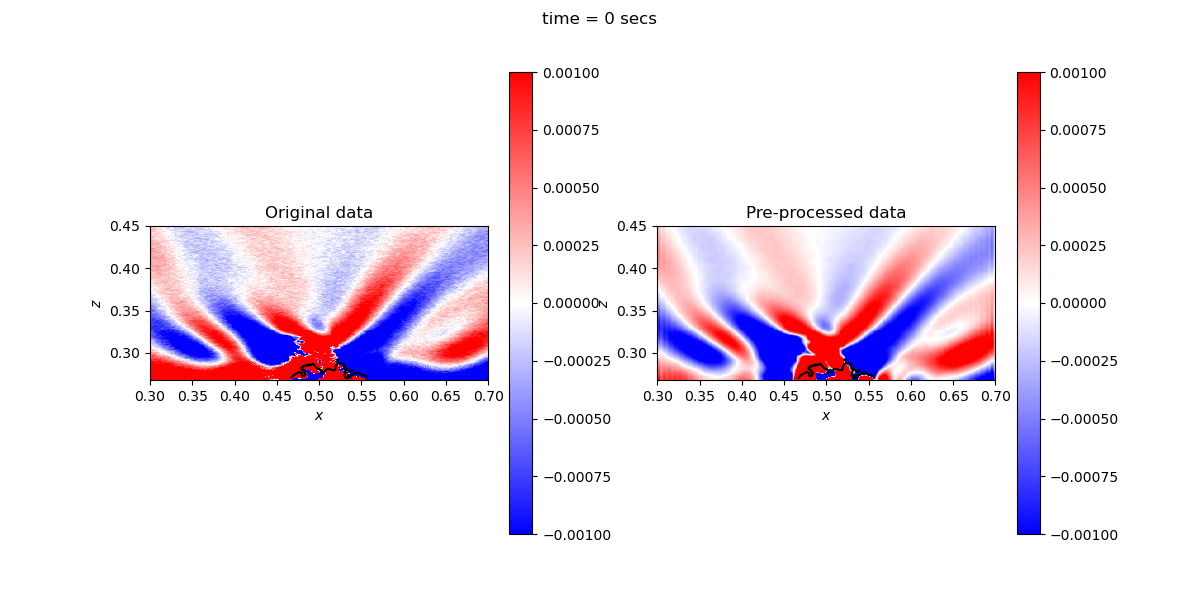

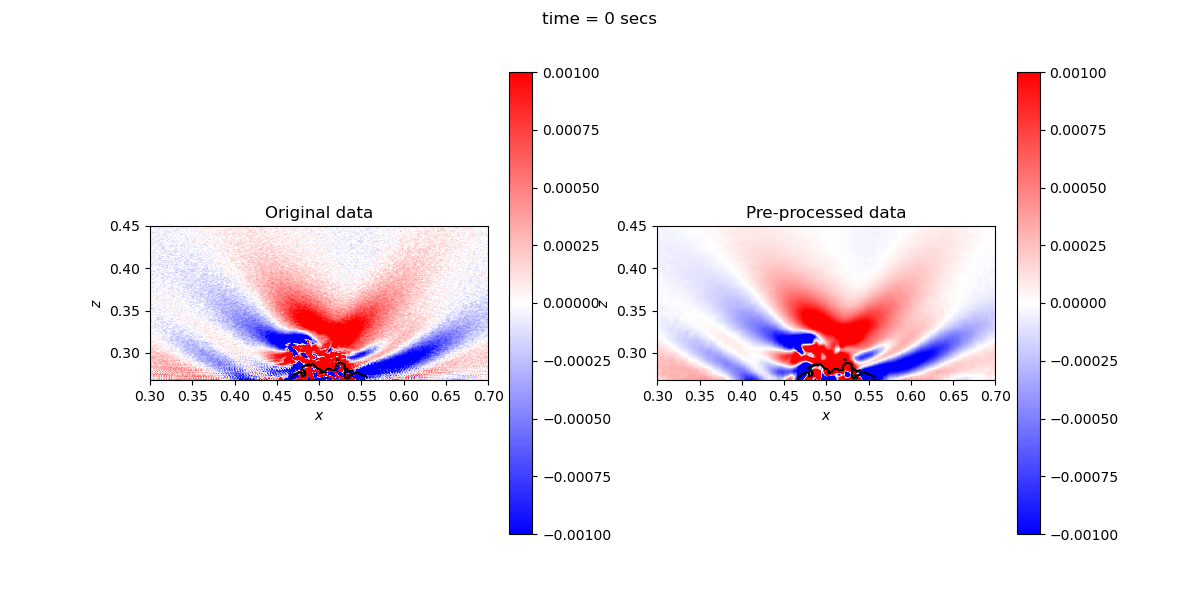

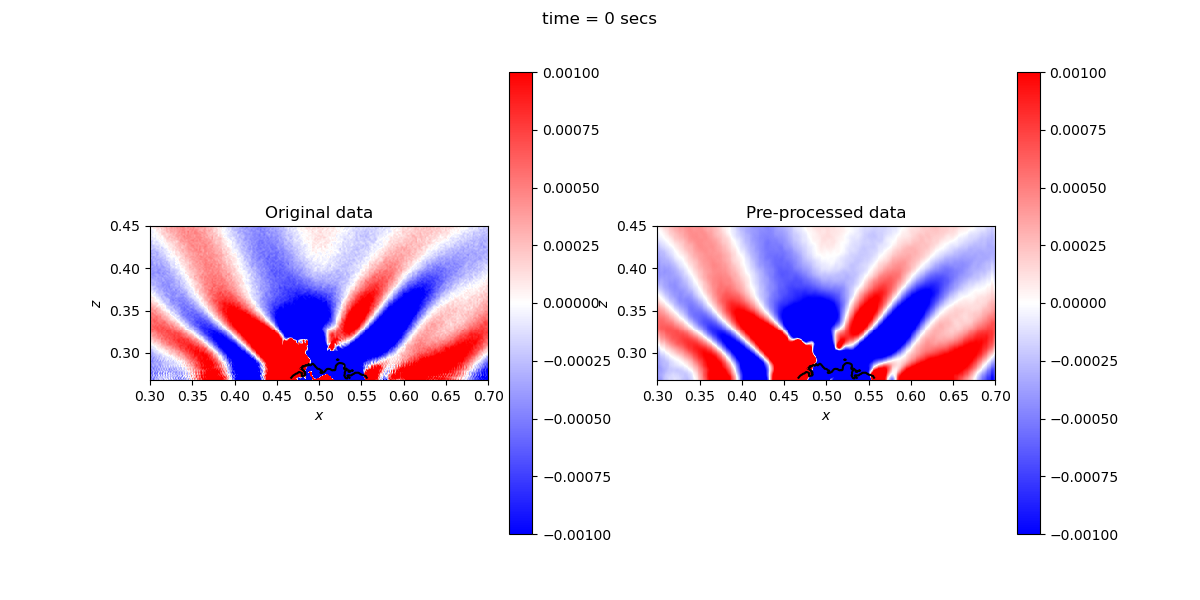

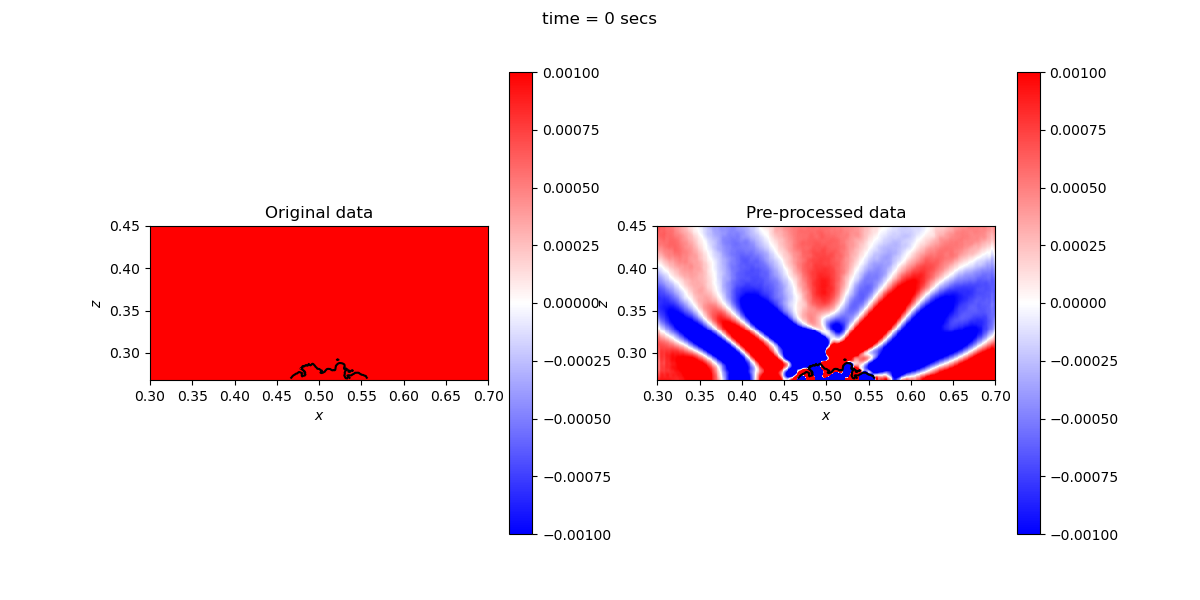

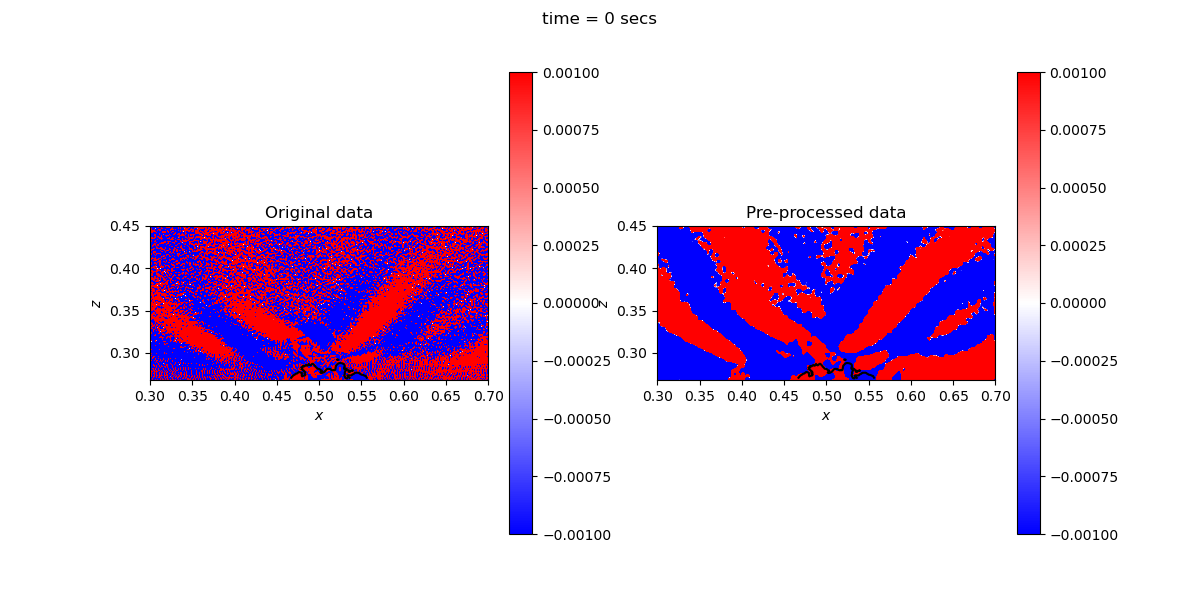

In [9]:
snapshots = [data[::filter_step][i] for i in range(len(times))]
print(snapshots[0].shape)
print(len(snapshots))

ncol = 4
if len(snapshots) % ncol != 0:
    rnum = len(snapshots)//ncol + 1
else:
    rnum = len(snapshots)//ncol

if plotting:
    for prep_idx in range(len(data_pack)):
        mode_fig, mode_anim = plot_2vars(data_orig[::filter_step][:,:,:,prep_idx], np.array(snapshots)[:,:,:,prep_idx],  "Original data", "Pre-processed data")
    
        print("Initialising mp4 writer...")
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1/(filter_step*md['SAVE_STATS_DT_FINE']), bitrate=1800)
    
        print("Starting plot...")
        anim = animation.FuncAnimation(mode_fig, mode_anim, interval=1000*filter_step*md['SAVE_STATS_DT_FINE'], frames=len(times), repeat=True)
        now = datetime.now()
    
        if save:
            save_fig(anim, '/home/cwp29/tmp/pre-processing.mp4', anim=True, dpi=300)

In [10]:
dmd = DMD(svd_rank=-1)
dmd.fit(snapshots)

In [11]:
# Dump DMD info into arrays, then sort by frequency
dmd_eigs = dmd.eigs#/(md['SAVE_STATS_DT_FINE']*filter_step)
dmd_freqs = np.imag(np.log(dmd_eigs)/(md['SAVE_STATS_DT_FINE']*filter_step))/np.sqrt(md['N2'])
dmd_amps = dmd.amplitudes
dmd_svd = np.linalg.svd(dmd.snapshots, full_matrices=False, compute_uv=False)
dmd_svar = dmd_svd * 100/np.sum(dmd_svd)
dmd_modes = np.moveaxis(dmd.modes, -1, 0)
dmd_dynamics = dmd.dynamics

# Sorting
sort_indices = np.argsort(np.abs(dmd_freqs))
#print(np.abs(dmd_freqs[sort_indices]))
dmd_eigs = dmd_eigs[sort_indices]
dmd_freqs = dmd_freqs[sort_indices]
dmd_amps = dmd_amps[sort_indices]
dmd_svd = dmd_svd[sort_indices]
dmd_svar = dmd_svar[sort_indices]
dmd_modes = dmd_modes[sort_indices]
dmd_dynamics = dmd_dynamics[sort_indices]

dmd_u_ids = np.where(dmd_freqs >= 0)[0] # indices for modes with positive freq.
dmd_cc_ids = np.zeros_like(dmd_u_ids) # indices for corresponding cc modes

dmd_ufreqs = dmd_freqs[dmd_u_ids]
dmd_umodes = dmd_modes[dmd_u_ids]

nmodes = len(dmd_freqs)
numodes = len(dmd_ufreqs)

for i in range(numodes):
    f = dmd_ufreqs[i]
    if -f not in dmd_freqs:
        dmd_cc_ids[i] = i
    else:
        dmd_cc_ids[i] = list(dmd_freqs).index(-f)


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


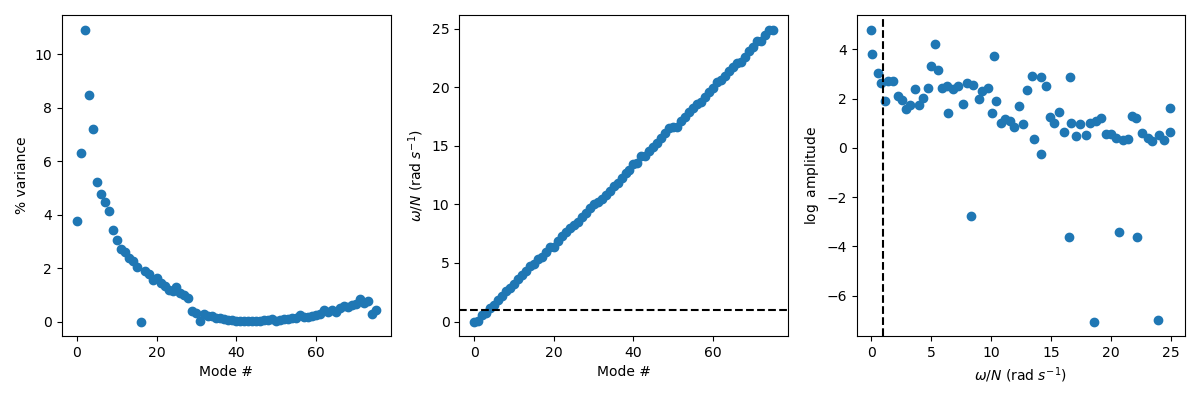

In [12]:
fig3, ax3 = plt.subplots(1,3, figsize=(12, 4))
#ax3[1].plot(np.abs(dmd.frequency*2*np.pi/(filter_step*md['SAVE_STATS_DT_FINE'])), "o")
ax3[2].plot(dmd_freqs[dmd_u_ids], np.log(dmd_amps[dmd_u_ids]), "o")
ax3[2].set_xlabel(r"$\omega/N$ (rad $s^{-1}$)")
ax3[2].axvline(np.sqrt(md['N2']), color='k', linestyle='--')
ax3[2].set_ylabel(r"$\log$ amplitude")

ax3[1].plot(dmd_freqs[dmd_u_ids], "o")
ax3[1].set_xlabel("Mode #")
ax3[1].set_ylabel(r"$\omega/N$ (rad $s^{-1}$)")
ax3[1].axhline(1, color='k', linestyle='--')

ax3[0].set_ylabel("% variance")
ax3[0].set_xlabel("Mode #")
ax3[0].plot(dmd_svar[dmd_u_ids] + dmd_svar[dmd_cc_ids], "o")

plt.tight_layout()

/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/pydmd/plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


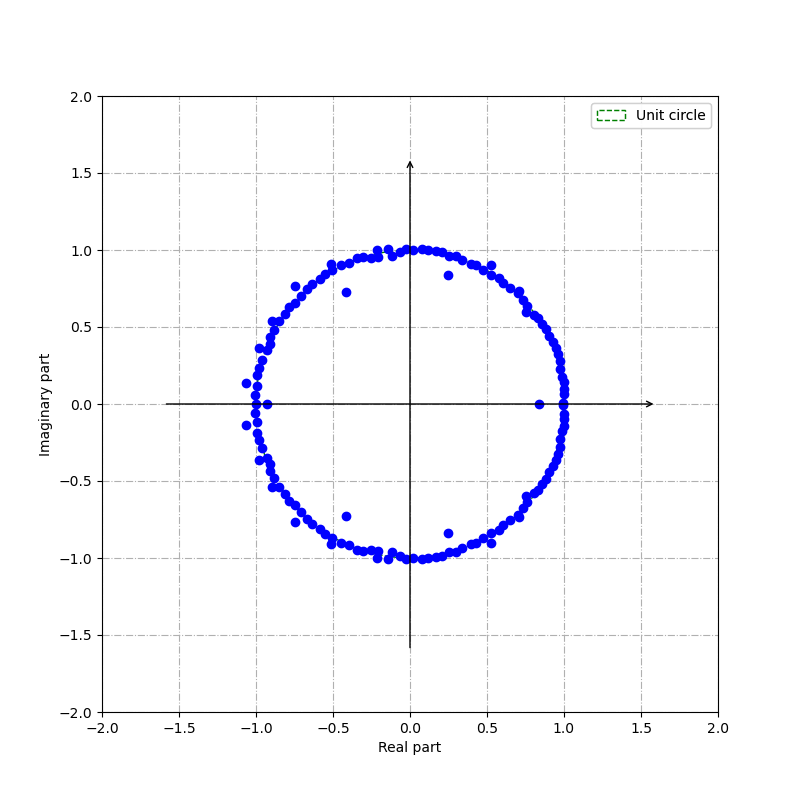

In [13]:
plot_eigs(dmd, figsize=(8,8))

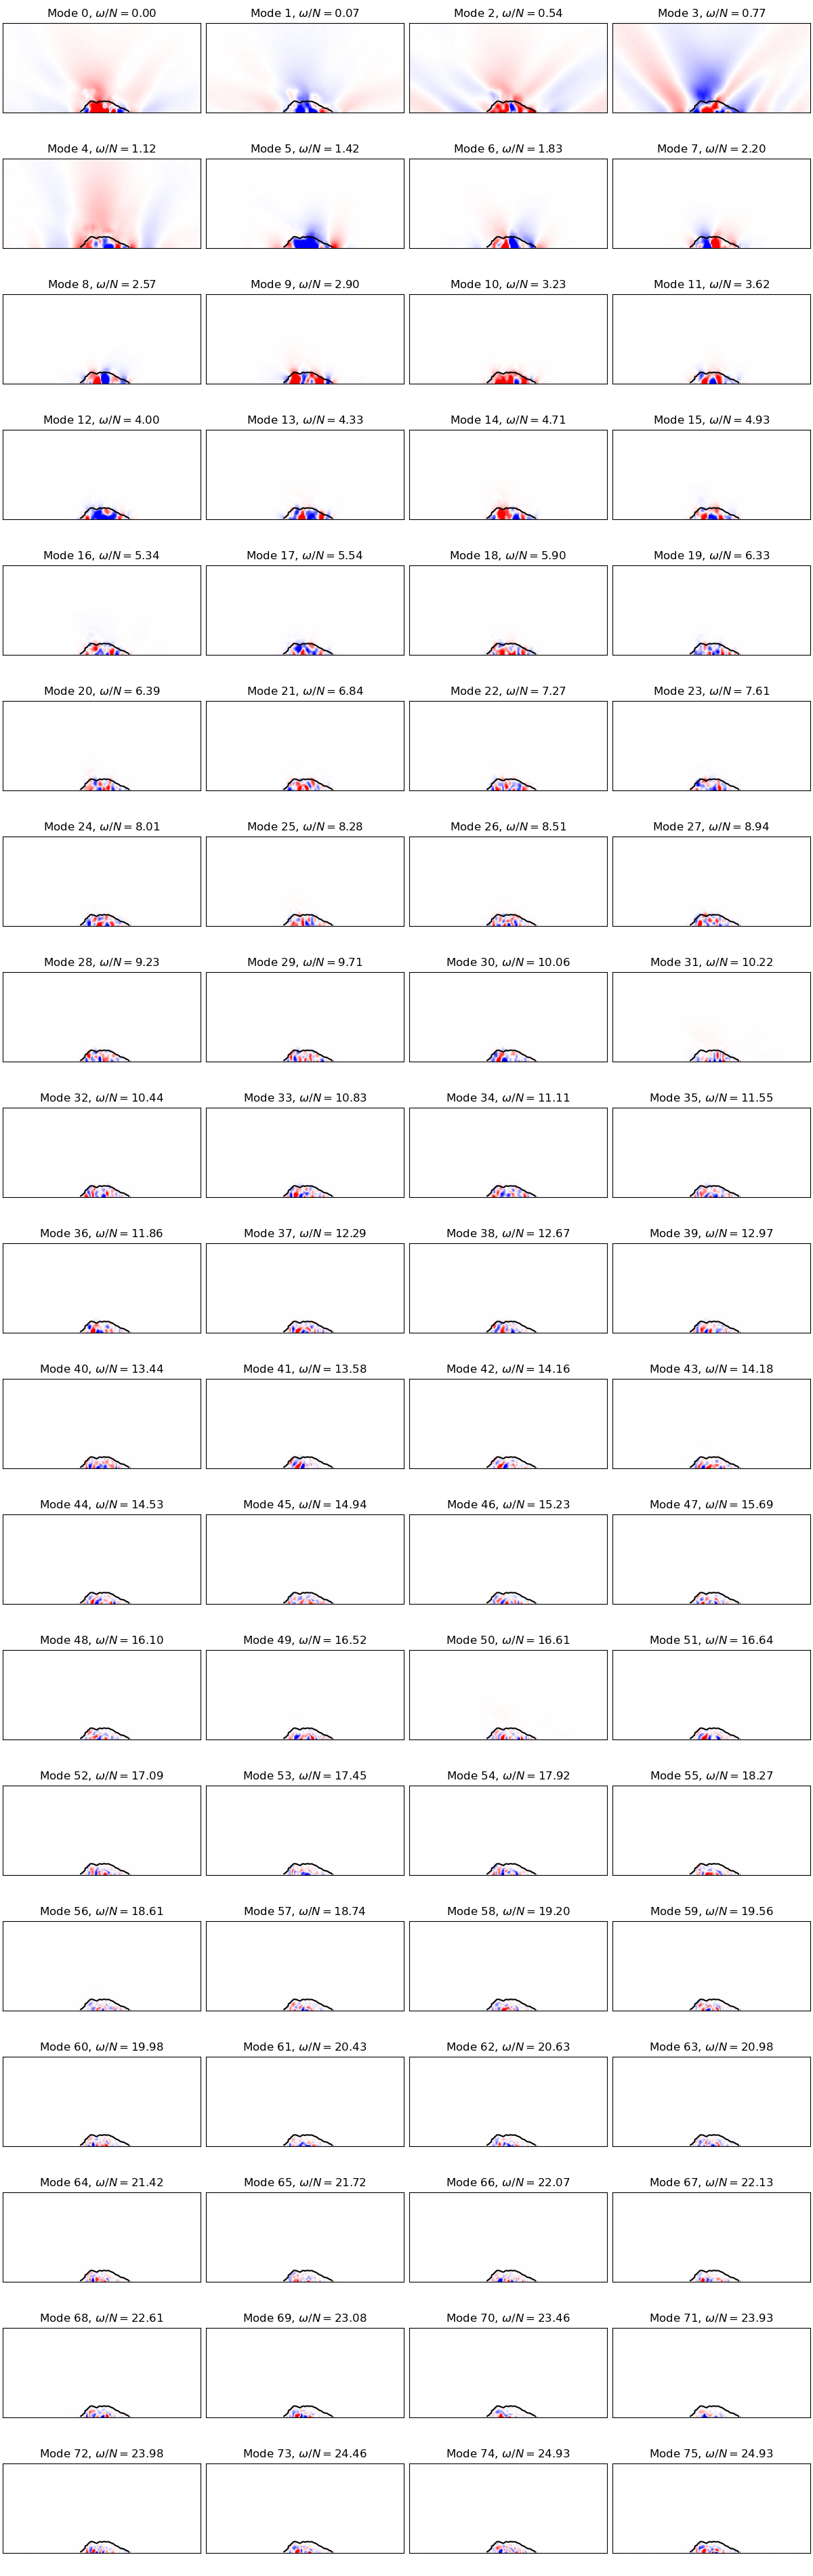

In [14]:
# Plot unique modes
ncol_modes = 4
if numodes % ncol_modes != 0:
    rnum_modes = numodes//ncol_modes + 1
else:
    rnum_modes = numodes//ncol_modes
    
fig6 = plt.figure(figsize=(3*ncol_modes, 2*rnum_modes), constrained_layout=True)

for id_subplot, snapshot in enumerate(dmd_umodes, start=1):
    plt.subplot(rnum_modes, ncol_modes, id_subplot)
    plt.pcolormesh(X, Y, snapshot.reshape(snapshots[0].shape).real[:,:,plot_idx], vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    plt.contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
    plt.xlim(*xlims)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_title(r"Mode {0}, $\omega/N={1:.2f}$".format(id_subplot-1, dmd_ufreqs[id_subplot-1]))
    plt.gca().set_aspect(1)


[0.         0.06711137 0.53612159 0.77009087]


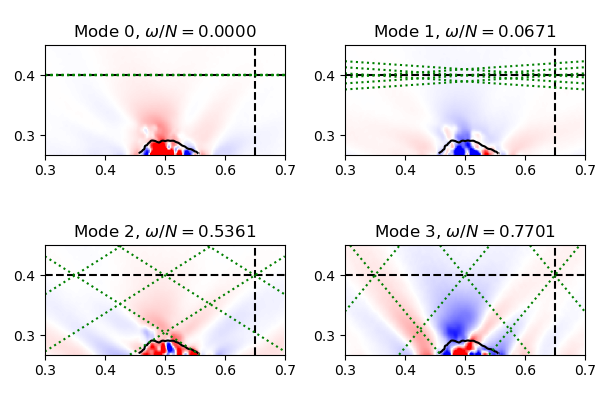

In [15]:
# Plot wave modes
dmd_w_ids = np.where(np.logical_and(0 <= dmd_ufreqs, dmd_ufreqs <= 1))[0]
nwmodes = len(dmd_w_ids)
print(dmd_ufreqs[dmd_w_ids])

ncol_wmodes = 2
if nwmodes % ncol_wmodes != 0:
    rnum_wmodes = nwmodes//ncol_wmodes + 1
else:
    rnum_wmodes = nwmodes//ncol_wmodes
    
fig7 = plt.figure(figsize=(3*ncol_wmodes, 2*rnum_wmodes), constrained_layout=True)

mode_num = -1
plotted_freqs = []
for i in range(nwmodes):
    snapshot = dmd_umodes[dmd_w_ids[i]]
    plt.subplot(rnum_wmodes, ncol_wmodes, i+1)
    plt.pcolormesh(X, Y, snapshot.reshape(snapshots[0].shape).real[:,:,plot_idx], vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    plt.contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
    plt.axvline(xplot, color='k', linestyle='--')
    plt.axhline(zplot, color='k', linestyle='--')
    plt.xlim(*xlims)
    plt.gca().set_title(r"Mode {0}, $\omega/N = {1:.4f}$".format(dmd_w_ids[i], dmd_ufreqs[dmd_w_ids[i]]))
    plt.gca().set_aspect(1)

    for xstart in np.linspace(md['LX']-xplot, xplot, 3):
        plt.axline((xstart, zplot), slope=1/np.tan(np.arccos(dmd_ufreqs[dmd_w_ids[i]])), color='g', linestyle=':')
        plt.axline((xstart, zplot), slope=-1/np.tan(np.arccos(dmd_ufreqs[dmd_w_ids[i]])), color='g', linestyle=':')

if save:
    save_fig(fig7, '/home/cwp29/tmp/unique_modes.jpg', dpi=300)

In [16]:
# Reconstructed data from wave modes only
def reconstruct_mode(unique_index):
    reconstructed = np.zeros_like(snapshots, dtype=np.complex128)
    
    for i in range(len(times)):
        reconstructed[i] += dmd_dynamics[dmd_u_ids[unique_index]][i] * dmd_modes[dmd_u_ids[unique_index]].reshape(snapshots[0].shape)# + time_evol_cc[i] * dmd_modes[dmd_cc_ids[unique_index]].reshape(snapshots[0].shape)

    return np.real(reconstructed)

In [17]:
def plot_mode_HT(mode_snapshots, mode_freq):
    global cont1, cont2, cont3, cont4
    # Hilbert transform
    
    freq_m = np.fft.fftfreq(mode_snapshots.shape[0])*2*np.pi/md['SAVE_STATS_DT_FINE']
    wavenumber_z = -np.fft.fftfreq(mode_snapshots.shape[1])*2*np.pi*md['Nz']/md['LZ']
    wavenumber_x = -np.fft.fftfreq(mode_snapshots.shape[2])*2*np.pi*md['Nx']/md['LX']
    
    # Dimension sizes from large to small: x, z, t
    
    waves_right = np.copy(mode_snapshots)
    waves_left = np.copy(mode_snapshots)
    waves_up = np.copy(mode_snapshots)
    
    # FFT in x
    waves_x_r = np.fft.fft(waves_right, axis=2)
    waves_x_r[:, :, wavenumber_x <= 0] = 0 # filter out left moving waves (giving right only)
    waves_filtered_r = np.fft.ifft(waves_x_r, axis=2)
    
    waves_x_l = np.fft.fft(waves_left, axis=2)
    waves_x_l[:, :, wavenumber_x >= 0] = 0 #filter out right moving waves (giving left only)
    waves_filtered_l = np.fft.ifft(waves_x_l, axis=2)
    
    waves_x_u = np.fft.fft(waves_up, axis=2)
    waves_filtered_u = np.fft.ifft(waves_x_u, axis=2)
    
    # FFT in z
    waves_z_r = np.fft.fft(waves_filtered_r, axis=1)
    waves_filtered_r = np.fft.ifft(waves_z_r, axis=1)
    
    waves_z_l = np.fft.fft(waves_filtered_l, axis=1)
    waves_filtered_l = np.fft.ifft(waves_z_l, axis=1)
    
    waves_z_u = np.fft.fft(waves_filtered_u, axis=1)
    # band pass around characteristic k_z
    k_zc = -k_xc * np.sqrt(1 - (omega_c**2)/md['N2'])
    waves_z_u[:, np.logical_or(wavenumber_z < 5*k_zc, wavenumber_z > 0.5*k_zc), :] = 0 #remove upward propagating waves
    a = wavenumber_z[5*k_zc <= wavenumber_z]
    print("z bandpass: ", a[a <= 0.5*k_zc])
    waves_filtered_u = np.fft.ifft(waves_z_u, axis=1)
    
    #FFT in t
    waves_t_r = np.fft.fft(waves_filtered_r, axis=0)
    waves_t_r[freq_m <= 0, :, :] = 0 # zero out negative freq.
    waves_t_r *= 2 # preserve energy
    waves_filtered_r = np.real(np.fft.ifft(waves_t_r, axis=0))
    
    waves_t_l = np.fft.fft(waves_filtered_l, axis=0)
    waves_t_l[freq_m <= 0, :, :] = 0 # zero out negative freq.
    waves_t_l *= 2 # preserve energy
    waves_filtered_l = np.real(np.fft.ifft(waves_t_l, axis=0))
    
    waves_t_u = np.fft.fft(waves_filtered_u, axis=0)
    waves_t_u[freq_m <= 0, :, :] = 0 # zero out negative freq.
    waves_t_u *= 2 # preserve energy
    waves_filtered_u = np.real(np.fft.ifft(waves_t_u, axis=0))

    # Set up figure
    non_dim_times = np.arange(len(times))*filter_step*md['SAVE_STATS_DT_FINE']/buoy_per
    print(non_dim_times)
    
    print("Setting up data arrays...")
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    ims = np.array([[None,None],[None, None]])
    cb = np.array([[None,None], [None, None]])
    
    print("Setting up initial plot...")
    ims[0,0] = axs[0,0].pcolormesh(X, Y, mode_snapshots[-1][:, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
    ims[0,1] = axs[0,1].pcolormesh(X, Y, waves_filtered_u[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
    ims[1,0] = axs[1,0].pcolormesh(X, Y, waves_filtered_l[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
    ims[1,1] = axs[1,1].pcolormesh(X, Y, waves_filtered_r[-1, :, :, plot_idx], cmap='bwr', norm=colors.CenteredNorm())
    
    cont1 = axs[0,0].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    cont2 = axs[0,1].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    cont3 = axs[1,0].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    cont4 = axs[1,1].contour(Xf, Yf, phi_snapshots[-1], levels=[phi_contour], colors='k')
    
    cb[0,0] = plt.colorbar(ims[0,0],ax=axs[0,0])
    cb[0,1] = plt.colorbar(ims[0,1],ax=axs[0,1])
    cb[1,0] = plt.colorbar(ims[1,0],ax=axs[1,0])
    cb[1,1] = plt.colorbar(ims[1,1],ax=axs[1,1])
    
    ims[0,0].set_clim(-clim, clim)
    ims[0,1].set_clim(-clim, clim)
    ims[1,0].set_clim(-clim, clim)
    ims[1,1].set_clim(-clim, clim)
    
    axs[0,0].set_xlim(*xlims)
    axs[0,1].set_xlim(*xlims)
    axs[1,0].set_xlim(*xlims)
    axs[1,1].set_xlim(*xlims)
    
    fig.suptitle("time = 0 secs")
    axs[0,0].set_ylabel("$z$")
    axs[0,1].set_ylabel("$z$")
    axs[0,0].set_xlabel("$x$")
    axs[0,1].set_xlabel("$x$")
    axs[1,0].set_ylabel("$z$")
    axs[1,1].set_ylabel("$z$")
    axs[1,0].set_xlabel("$x$")
    axs[1,1].set_xlabel("$x$")
    
    axs[0,0].set_aspect(1)
    axs[0,1].set_aspect(1)
    axs[1,0].set_aspect(1)
    axs[1,1].set_aspect(1)
    
    axs[0,0].set_title(r"Mode with $\omega$ = {0:.2f}".format(mode_freq))
    axs[0,1].set_title(r"Filtered: $k_z < 0$")
    axs[1,0].set_title(r"Filtered: $k_x < 0$")
    axs[1,1].set_title(r"Filtered: $k_x > 0$")
    
    def animate(step):
        global cont1, cont2, cont3, cont4
        ims[0,0].set_array(mode_snapshots[step][:, :, plot_idx].ravel())
        ims[0,1].set_array(waves_filtered_u[step, :, :, plot_idx].ravel())
        ims[1,0].set_array(waves_filtered_l[step, :, :, plot_idx].ravel())
        ims[1,1].set_array(waves_filtered_r[step, :, :, plot_idx].ravel())
        
        fig.suptitle(r"$t = {0:.2f}\, T_b$".format(non_dim_times[step]))
    
        for c in cont1.collections:
            c.remove()
        for c in cont2.collections:
            c.remove()
        for c in cont3.collections:
            c.remove()
        for c in cont4.collections:
            c.remove()
    
        cont1 = axs[0,0].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        cont2 = axs[0,1].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        cont3 = axs[1,0].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        cont4 = axs[1,1].contour(Xf, Yf, phi_snapshots[step], levels=[phi_contour], colors='k')
        
        return ims.flatten(),
    
    return fig, animate

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves/jfunctions.py:22: RuntimeWarning: invalid value encountered in divide
  angle = np.arccos(np.abs(KX) / radius)


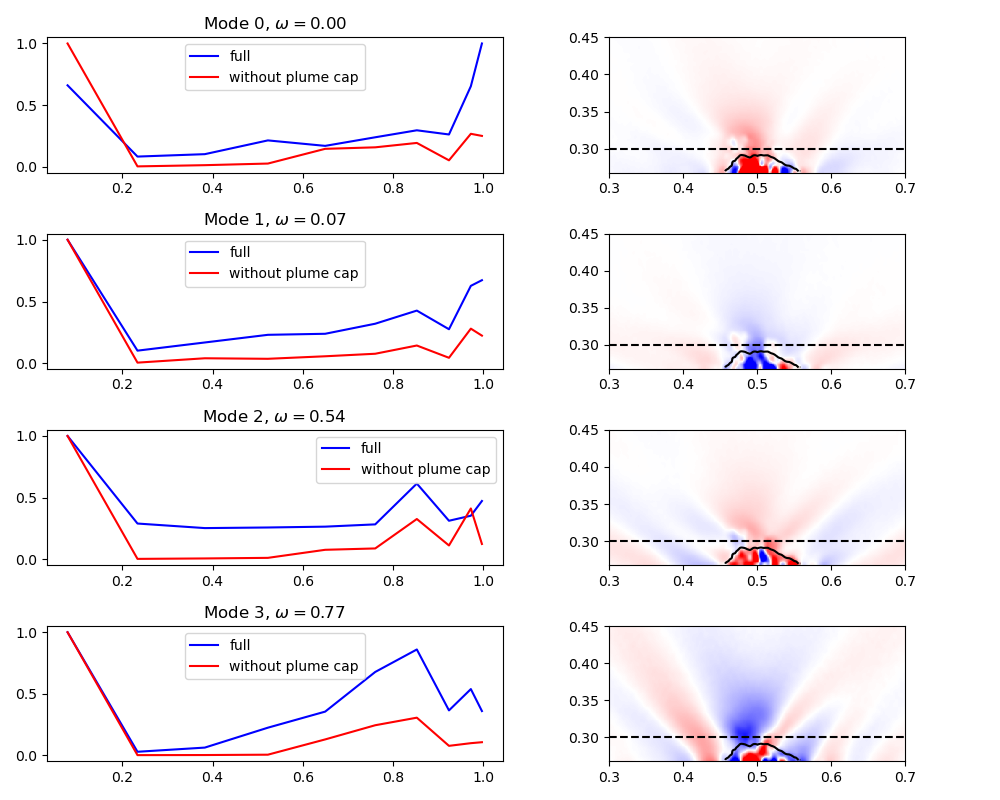

In [18]:
# Frequency spectrum within unique modes
fig7 = plt.figure(figsize=(10, 2*nwmodes))

N = np.sqrt(md['N2'])

cap_height = 0.3
cap_idx = get_index(cap_height, gzf_trunc)

for i in range(nwmodes):
    frame = dmd_umodes[dmd_w_ids[i]].reshape(snapshots[0].shape)

    plt.subplot(nwmodes, 2, 2*i+1)
    plt.gca().set_title(r"Mode {0}, $\omega = {1:.2f}$".format(dmd_w_ids[i], dmd_ufreqs[dmd_w_ids[i]]))

    
    angles, spectrum = angle_spectrum(np.real(frame[:,:,plot_idx]), md['LX']/md['Nx'], md['LZ']/md['Nz'], nbins=11)
    plt.plot(angles, spectrum/np.max(spectrum), color='b', label="full")
    
    angles, spectrum = angle_spectrum(np.real(frame[cap_idx:,:,plot_idx]), md['LX']/md['Nx'], md['LZ']/md['Nz'], nbins=11)
    plt.plot(angles, spectrum/np.max(spectrum), color='r', label="without plume cap")

    plt.legend()

    #kzs_pos = kzs[kzs >= 0]
    #kz_pos_spectrum = kz_spectrum[kzs >= 0]
    #kz_peaks, kz_props = scipy.signal.find_peaks(kz_pos_spectrum, prominence=0.2*np.max(kz_pos_spectrum))
    #plt.plot(kzs_pos[kz_peaks], kz_pos_spectrum[kz_peaks], 'o', color='r')

    plt.subplot(nwmodes, 2, 2*i+2)
    plt.pcolormesh(X, Y, np.real(frame[:,:,plot_idx]), vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    plt.contour(Xf, Yf, np.mean(phi_snapshots, axis=0), levels=[phi_contour], colors='k')
    plt.axhline(cap_height, color='k', linestyle='--')
    plt.xlim(*xlims)
    plt.gca().set_aspect(1)
    

plt.tight_layout()
if save:
    save_fig(fig7, '/home/cwp29/tmp/wavenumber_spectra.jpg', dpi=300)

z bandpass:  [ -34.65886089  -69.31772178 -103.97658266]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98]
Setting up data arrays...
Setting up initial plot...
Initialising mp4 writer...
Starting plot...


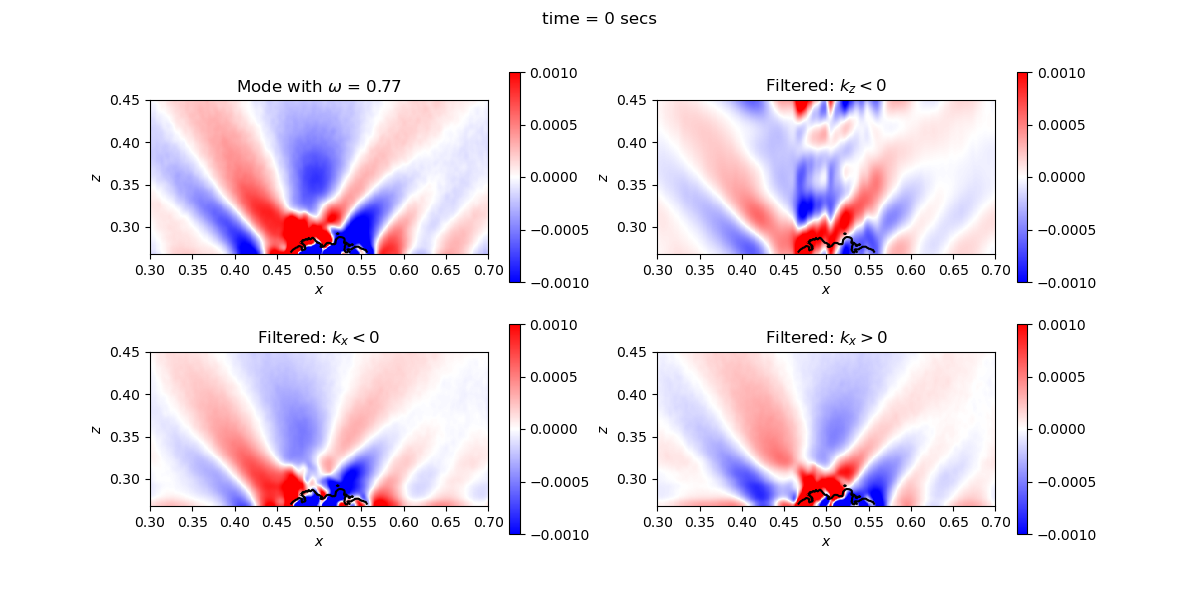

In [19]:
mode_fig, mode_anim = plot_mode_HT(reconstruct_mode(dmd_w_ids[3]), dmd_ufreqs[dmd_w_ids[3]])

print("Initialising mp4 writer...")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1/(filter_step*md['SAVE_STATS_DT_FINE']), bitrate=1800)

print("Starting plot...")
anim = animation.FuncAnimation(mode_fig, mode_anim, interval=1000*filter_step*md['SAVE_STATS_DT_FINE'], frames=len(times), repeat=True)
now = datetime.now()

if save:
    save_fig(anim, '/home/cwp29/tmp/movie.mp4', anim=True, dpi=300)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
(1.0009348324681393+0.09742811480377045j)
(-13.756166032004618+1.4641430320662074j)
[ 1.        +0.j          1.00093483+0.09742811j  0.9923783 +0.19503839j
  0.97430379+0.29190626j  0.94677472+0.38710373j  0.90994501+0.47970808j
  0.8640586 +0.56881075j  0.80944819+0.6535261j   0.74653308+0.73300005j
  0.67581615+0.80641859j  0.59788008+0.87301595j  0.5133827 +0.9320824j
  0.42305159+0.

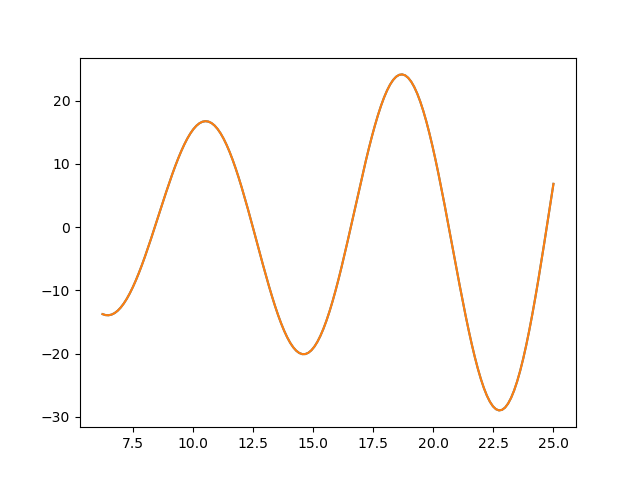

In [20]:
unique_index = 3

reconstructed = np.zeros_like(snapshots, dtype=np.complex128)

plt.figure()
plt.plot(.5*(times_trunc[1:] + times_trunc[:-1]), dmd_dynamics[dmd_u_ids[unique_index]])
print(dmd.dmd_timesteps)
#plt.plot(.5*(times_trunc[1:] + times_trunc[:-1]), dmd_amps[dmd_u_ids[unique_index]]*np.exp(dmd_eigs[dmd_u_ids[unique_index]]*(times_trunc[1:]-times_trunc[0])/md['SAVE_STATS_DT_FINE']))
print(dmd_eigs[dmd_u_ids[unique_index]])
print(dmd_amps[dmd_u_ids[unique_index]])
print(np.power(dmd_eigs[dmd_u_ids[unique_index]],(dmd.dmd_timesteps-dmd.original_time["t0"])/dmd.original_time["dt"]))
plt.plot(.5*(times_trunc[1:]+times_trunc[:-1]), dmd_amps[dmd_u_ids[unique_index]]*np.power(dmd_eigs[dmd_u_ids[unique_index]],(dmd.dmd_timesteps-dmd.original_time["t0"])/dmd.original_time["dt"]))

(-122.07593662075865+9.059419880941277e-14j)
(3.5259844879792226-44.91308837856932j)


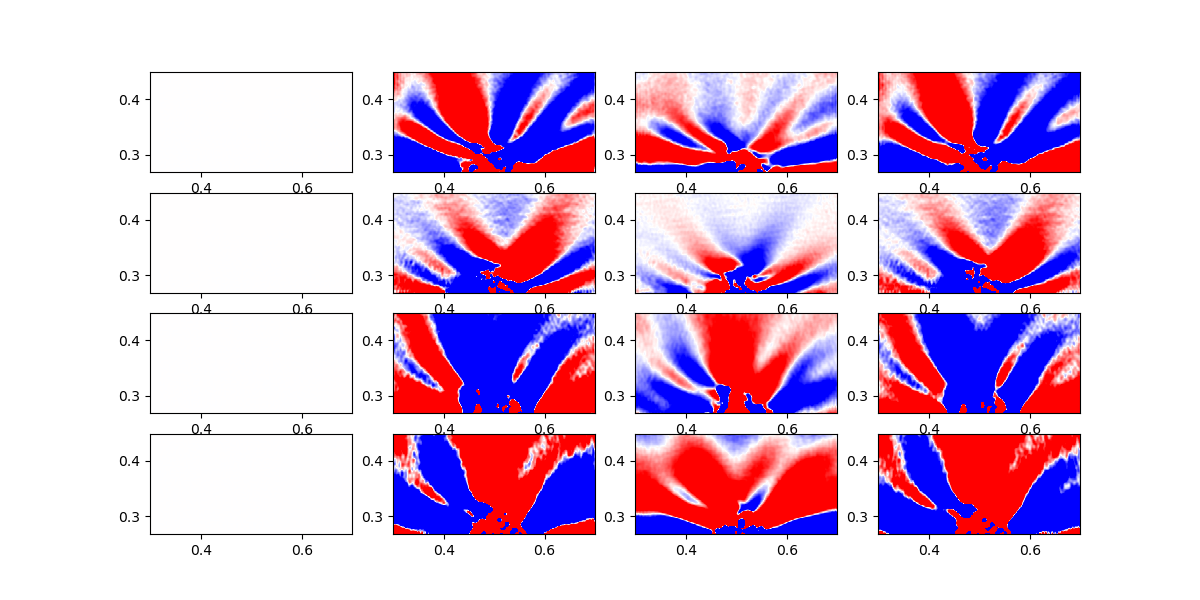

In [21]:
fig, ax = plt.subplots(4,4, figsize=(12,6))
print(dmd_amps[dmd_u_ids[0]])
print(dmd_amps[dmd_u_ids[1]])

for plot_idx in range(4):
    ax[plot_idx, 0].pcolormesh(X, Y, np.mean(np.array(snapshots), axis=0)[:,:,plot_idx], vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    ax[plot_idx, 1].pcolormesh(X, Y, np.real(dmd_amps[dmd_u_ids[0]]*dmd_umodes[0].reshape(snapshots[0].shape)[:,:,plot_idx]), vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    ax[plot_idx, 2].pcolormesh(X, Y, np.real(dmd_amps[dmd_u_ids[1]]*dmd_umodes[1].reshape(snapshots[0].shape)[:,:,plot_idx]), vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')
    ax[plot_idx, 3].pcolormesh(X, Y, np.real(dmd_amps[dmd_u_ids[1]]*dmd_umodes[1].reshape(snapshots[0].shape)[:,:,plot_idx]+dmd_amps[dmd_u_ids[0]]*dmd_umodes[0].reshape(snapshots[0].shape)[:,:,plot_idx]), vmin=-0.1*clim, vmax=0.1*clim, cmap='bwr')

In [22]:
%store u

Stored 'u' (ndarray)
